# Predicting Disease Associate Genes Relationship (Part 1)

This notebook is designed to begin the process of predicting the disease associates gene (DaG) relationship. The first step this notebook takes is labeling our training sentences (split = 0) using our hand crafted label functions. Following the labeling process, the next step is to train a generative model to estimate the true training label ($\hat{Y}$) given the output of our label functions. From there the last step is to train word embedding vectors using facebook's [FastText](https://fasttext.cc/). These word embedding vectors will be used to train the discriminator models in the suceeding notebook.

## Set up the environment

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import defaultdict
import os
import pickle
import sys

sys.path.append(os.path.abspath('../../../modules'))

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve
from tqdm import tqdm_notebook

In [2]:
#Set up the environment
username = "danich1"
password = "snorkel"
dbname = "pubmeddb"

#Path subject to change for different os
database_str = "postgresql+psycopg2://{}:{}@/{}?host=/var/run/postgresql".format(username, password, dbname)
os.environ['SNORKELDB'] = database_str

from snorkel import SnorkelSession
session = SnorkelSession()

In [3]:
from snorkel.learning.pytorch.rnn.rnn_base import mark_sentence
from snorkel.learning.pytorch.rnn.utils import candidate_to_tokens
from snorkel.models import Candidate, candidate_subclass

from metal.label_model import LabelModel
from metal.utils import plusminus_to_categorical

from gensim.models import FastText
from gensim.models import KeyedVectors

from utils.notebook_utils.label_matrix_helper import label_candidates, get_auc_significant_stats
from utils.notebook_utils.dataframe_helper import load_candidate_dataframes
from utils.notebook_utils.plot_helper import plot_curve, plot_label_matrix_heatmap

sys.path.append(os.path.abspath('data/label_functions'))
from disease_gene_lf_multitask import DG_LFS

In [4]:
DiseaseGene = candidate_subclass('DiseaseGene', ['Disease', 'Gene'])

In [5]:
quick_load = True

## Load the Data and Label the  Sentences

This block of code is designed to label the sentences using our label functions. All the sentences are located in our postgres database that is store locally on the lab machine. The labeling process is defined as follows: Given a candidate id use the sqlalchemy library to extract a candidate object. Take the object and pass it through a series of label functions that will output a 1, -1 or 0 depending on the rule set. Lastly take this output and form a sparse matrix that the generative model will use. Since these steps are pretty linear, we parallelized this process using python's multithreading library. Even then labeling a set of ~600000 sentences takes about 3 hours.

In [6]:
total_candidates_df = pd.read_table("../dataset_statistics/data/all_dg_candidates_map.tsv.xz")
total_candidates_df.head(2)

,entrez_gene_id,gene_symbol,doid_id,doid_name,split,compound_mention_count,disease_mention_count,gene_mention_count,sentence_id,text,sen_length,candidate_id
0,1,A1BG,DOID:1324,lung cancer,0,0.0,1.0,2.0,78840952,We revealed that A1BG and LRG1 were overexpres...,30,26725291
1,1,A1BG,DOID:1324,lung cancer,0,0.0,1.0,1.0,86234572,METHODS: HEK293 cells expressing specific indi...,53,29874761


In [7]:
spreadsheet_names = {
    'dev': 'data/sentences/sentence_labels_dev.xlsx',
    'test': 'data/sentences/sentence_labels_test.xlsx'
}

In [8]:
candidate_dfs = {
    key:load_candidate_dataframes(spreadsheet_names[key])
    for key in spreadsheet_names
}

for key in candidate_dfs:
    print("Size of {} set: {}".format(key, candidate_dfs[key].shape[0]))

Size of dev set: 1000
Size of test set: 1000


In [9]:
#Save data for cluster
(
    candidate_dfs['dev'][["candidate_id", "curated_dsh"]]
    .to_csv("single_task_data/dev_labels.tsv", index=False, sep="\t")
)

In [10]:
lfs = list(DG_LFS["DaG"].values())
lf_names = list(DG_LFS["DaG"].keys())

In [11]:
if not quick_load:
    label_matricies = {
        'train':label_candidates(
            session, 
            (
                total_candidates_df
                .query("split==0&disease_mention_count==1&gene_mention_count==1")
                .candidate_id
                .values
                .tolist()
            ),
            lfs, 
            lf_names,
            num_threads=10,
            batch_size=50000,
            multitask=False
        )
    }

In [ ]:
if not quick_load:
    # Check to make sure the label functions match up with the candidate objects
    ids=label_matricies['train'].candidate_id.head(5).tolist()
    candidate_list = session.query(DiseaseGene).filter(DiseaseGene.id.in_(ids)).all()
    for candidate in tqdm_notebook(candidate_list):
        correct_output = list(map(lambda fn: fn(candidate), lfs))
        test_output = label_matricies['train'].query("candidate_id==@candidate.id").fillna(0).values.tolist()[0]
        for pair in zip(correct_output, test_output[:-1]):
            assert pair[0] == pair[1]

In [12]:
if not quick_load:
    label_matricies.update({
        key:label_candidates(
            session, 
            candidate_dfs[key]['candidate_id'].values.tolist(),
            lfs, 
            lf_names,
            num_threads=10,
            batch_size=50000,
            multitask=False
        )
        for key in candidate_dfs
    })

In [13]:
# Save the label matricies to a file for future loading/error analysis
if not quick_load:
    (
        label_matricies['train']
        .sort_values("candidate_id")
        .to_csv("single_task_data/train_sparse_matrix.tsv", sep="\t", index=False)
    )
    (
        label_matricies['dev']
        .sort_values("candidate_id")
        .to_csv("single_task_data/dev_sparse_matrix.tsv", sep="\t", index=False)
    )
    (
        label_matricies['test']
        .sort_values("candidate_id")
        .to_csv("single_task_data/test_sparse_matrix.tsv", sep="\t", index=False)
    )
# Quick load the label matricies
else:
    label_destinations = {
        'train':"single_task_data/train_sparse_matrix.tsv",
        'dev':"single_task_data/dev_sparse_matrix.tsv",
        'test':"single_task_data/test_sparse_matrix.tsv"
    }
    label_matricies = {
        key:pd.read_table(label_destinations[key]).to_sparse()
        for key in label_destinations
    }

In [14]:
# Important Note Snorkel Metal uses a different coding scheme
# than the label functions output. (2 for negative instead of -1).
# This step corrects this problem by converting -1s to 2
correct_L = plusminus_to_categorical(
    label_matricies['train']
    .sort_values("candidate_id")
    .drop("candidate_id", axis=1)
    .to_coo()
    .toarray()
)
correct_L_dev = plusminus_to_categorical(
    label_matricies['dev']
    .sort_values("candidate_id")
    .drop("candidate_id", axis=1)
    .to_coo()
    .toarray()
)
correct_L_test = plusminus_to_categorical(
    label_matricies['test']
    .sort_values("candidate_id")
    .drop("candidate_id", axis=1)
    .to_coo()
    .toarray()
)

label_model = LabelModel(K=2)

Could not find kwarg "K" in destination dict.


## Begin Training the Generative Model

In this section, we are going to train a generative model. This model is designed to estimate the best class a training point belongs to given a set of label functions ($P(\hat{Y} \mid \lambda_{1\ldots n})$). This is accomplished by estimating a parameter called mu, which is the probability of a label function emitting a 1 or 2 given the true class. ($P(\lambda_{j} = y | Y=y)$). Once mu is estimated, the final step is to use mu and calculate the above probability ($P(\hat{Y} \mid \lambda_{1\ldots n})$). We found the optimial model using a grid search. The hyperparameter we are tuning is the l2 norm and we set a grid starting from 0.01 all the way to 1. Luckily, the generative model is pretty fast to train so navigating this search space is pretty trivial.

In [15]:
regularization_grid = pd.np.round(pd.np.linspace(0.01, 1, num=15), 2)

In [16]:
grid_results = {}
for param in tqdm_notebook(regularization_grid):
    label_model.train_model(correct_L, n_epochs=1000, print_every=200, seed=100, lr=0.01, l2=param)
    grid_results[str(param)] = label_model.predict_proba(correct_L_dev)

HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

Computing O...
Estimating \mu...
[E:0]	Train Loss: 3.792
[E:200]	Train Loss: 0.209
[E:400]	Train Loss: 0.209
[E:600]	Train Loss: 0.209
[E:800]	Train Loss: 0.209
[E:999]	Train Loss: 0.209
Finished Training
Computing O...
Estimating \mu...
[E:0]	Train Loss: 2.944
[E:200]	Train Loss: 0.223
[E:400]	Train Loss: 0.223
[E:600]	Train Loss: 0.223
[E:800]	Train Loss: 0.223
[E:999]	Train Loss: 0.223
Finished Training
Computing O...
Estimating \mu...
[E:0]	Train Loss: 5.086
[E:200]	Train Loss: 0.255
[E:400]	Train Loss: 0.255
[E:600]	Train Loss: 0.255
[E:800]	Train Loss: 0.255
[E:999]	Train Loss: 0.255
Finished Training
Computing O...
Estimating \mu...
[E:0]	Train Loss: 3.500
[E:200]	Train Loss: 0.301
[E:400]	Train Loss: 0.301
[E:600]	Train Loss: 0.301
[E:800]	Train Loss: 0.301
[E:999]	Train Loss: 0.301
Finished Training
Computing O...
Estimating \mu...
[E:0]	Train Loss: 5.288
[E:200]	Train Loss: 0.358
[E:400]	Train Loss: 0.358
[E:600]	Train Loss: 0.358
[E:800]	Train Loss: 0.358
[E:999]	Train Loss:

In [17]:
auc_results = defaultdict(list)
f1_results = defaultdict(list)

for key in grid_results:
    precision, recall, _ = precision_recall_curve(candidate_dfs['dev']['curated_dsh'].values, grid_results[key][:,0])
    auc_results[key].append(auc(recall, precision))
    f1_results[key].append(f1_score(candidate_dfs['dev']['curated_dsh'].fillna(0), list(map(lambda x: 1 if x > 0.5 else 0, grid_results[key][:,0]))))
auc_df = pd.DataFrame.from_dict(auc_results)
f1_df = pd.DataFrame.from_dict(f1_results)

In [18]:
auc_df.transpose().sort_values(0, ascending=False).head(5)

,0
0.22,0.610543
0.08,0.605779
0.01,0.605261
0.15,0.602868
0.29,0.599077


In [19]:
f1_df.transpose().sort_values(0, ascending=False).head(5)

,0
0.43,0.586724
0.5,0.583170
0.36,0.582547
0.58,0.580952
0.86,0.580340


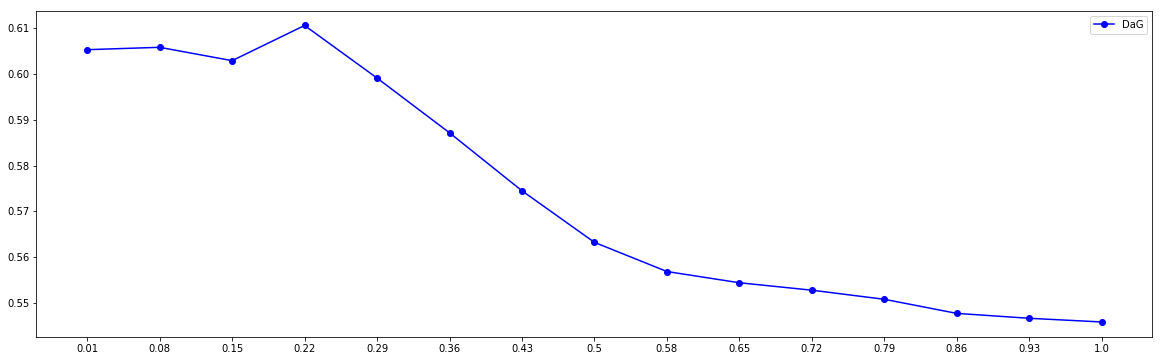

In [20]:
plt.figure(figsize=(20,6))
plt.plot(list(auc_df.transpose().index), auc_df.transpose()[0],"bo-", label="DaG", )
plt.legend()

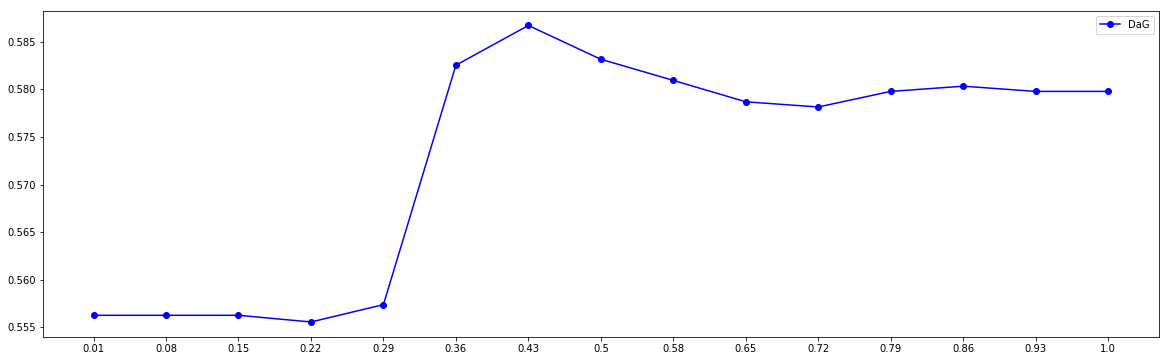

In [21]:
plt.figure(figsize=(20,6))
plt.plot(list(f1_df.transpose().index), f1_df.transpose()[0],"bo-", label="DaG", )
plt.legend()

These two graphs are interesting, because it defeats the intuition that a higher area under the precision-recall curve imples a higher f1 score. If one looks at the first graph the optmial area under the curve is at 0.22, but in F1 space the optimal point is 0.43. To get a better idea behind this, we will plot the actual precision recall curves below.

In [22]:
dev_predictions_df = pd.DataFrame.from_dict({key: grid_results[key][:,0] for key in grid_results})
dev_predictions_df.head(2)

,0.01,0.08,0.15,0.22,0.29,0.36,0.43,0.5,0.58,0.65,0.72,0.79,0.86,0.93,1.0
0,0.999318,0.999361,0.999450,0.999553,0.999650,0.999733,0.999794,0.999837,0.999736,0.999591,0.999524,0.999399,0.999314,0.999273,0.999266
1,0.064438,0.075640,0.110014,0.187059,0.344342,0.595992,0.831405,0.939963,0.970928,0.978909,0.982754,0.985148,0.986877,0.988263,0.989444


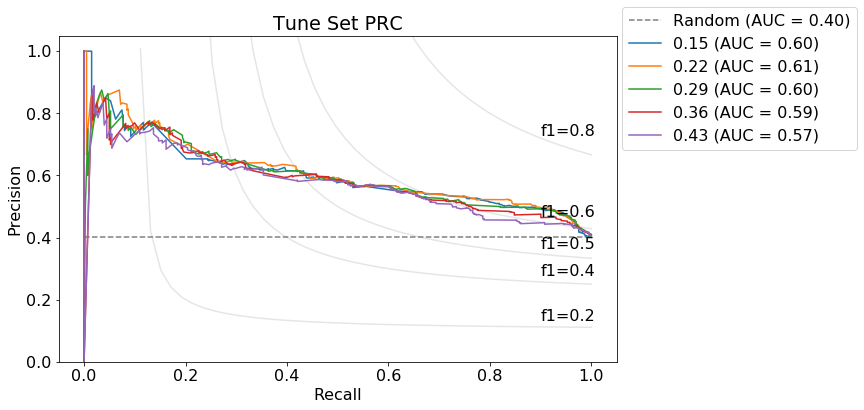

In [23]:
aucs=plot_curve(
    dev_predictions_df[["0.15", "0.22","0.29", "0.36", "0.43"]],
    candidate_dfs['dev'].curated_dsh, 
    plot_title="Tune Set PRC", 
    metric="PR", model_type="curve"
)

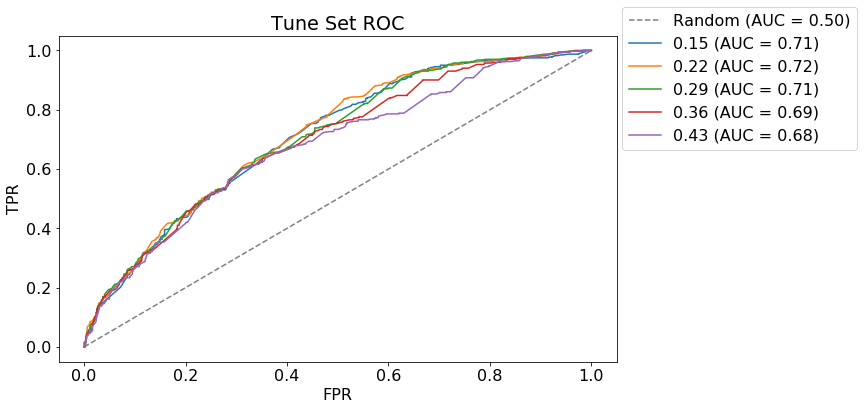

In [24]:
aucs=plot_curve(
    dev_predictions_df[["0.15", "0.22","0.29", "0.36", "0.43"]],
    candidate_dfs['dev'].curated_dsh, 
    plot_title="Tune Set ROC", 
    metric="ROC", 
    model_type="curve"
)

In [25]:
#Get Statistical Significance against ROCs
get_auc_significant_stats(
    candidate_dfs['dev'],
    aucs
)

mu: 120198.000000, sigma: 4478.061299


,auroc,u,z_u,p_value
0.15,0.708417,170300.5,11.188435,2.322790e-29
0.22,0.715330,171962.5,11.559578,3.301615e-31
0.29,0.707017,169964.0,11.113291,5.405007e-29
0.36,0.693782,166782.5,10.402828,1.203415e-25
0.43,0.677561,162883.0,9.532027,7.712103e-22


These curves were ploted zooming in on 0.22 and nearby points. These plots say that the best value for the l2 norm is 0.22. In the precision recall plot, the beginning shows the 0.22 model dominating the other models; however, when the thresholds starts to relax performance starts to become on par with the other models. This trend is different in the ROC curve where the 0.22 model maintains good performance, while the other models start to diverge when the threshold starts to decrease. By adding p-values towards the rocs, it shows that 0.22 is the most significant in comparison. Based on the evidence above I would argue that 0.22 is the best hyperparameter for this model.

In [31]:
(
    dev_predictions_df[['0.22']]
    .rename(
        index=str, 
        columns={
            "0.22":"gen_model"
        }
    )
    .assign(candidate_id=label_matricies['dev'].candidate_id.sort_values().values)
    .to_csv("single_task_data/gen_model_dev_set_pred.tsv", sep='\t', index=False)
)

In [32]:
label_model.train_model(correct_L, n_epochs=1000, print_every=200, seed=100, lr=0.01, l2=0.22)
predictions = label_model.predict_proba(correct_L_test)

Computing O...
Estimating \mu...
[E:0]	Train Loss: 2.784
[E:200]	Train Loss: 0.301
[E:400]	Train Loss: 0.301
[E:600]	Train Loss: 0.301
[E:800]	Train Loss: 0.301
[E:999]	Train Loss: 0.301
Finished Training


In [33]:
test_predictions_df = pd.DataFrame(predictions[:,0], columns=["Best Model (l2:0.22)"])
test_predictions_df.head(2)

,Best Model (l2:0.22)
0,0.039794
1,0.145750


In [34]:
(
    test_predictions_df
    .rename(
        index=str, 
        columns={
            "Best Model (l2:0.22)":"gen_model"
        }
    )
    .assign(candidate_id=label_matricies['test'].candidate_id.sort_values().values)
    .to_csv("single_task_data/gen_model_test_set_pred.tsv", sep='\t', index=False)
)

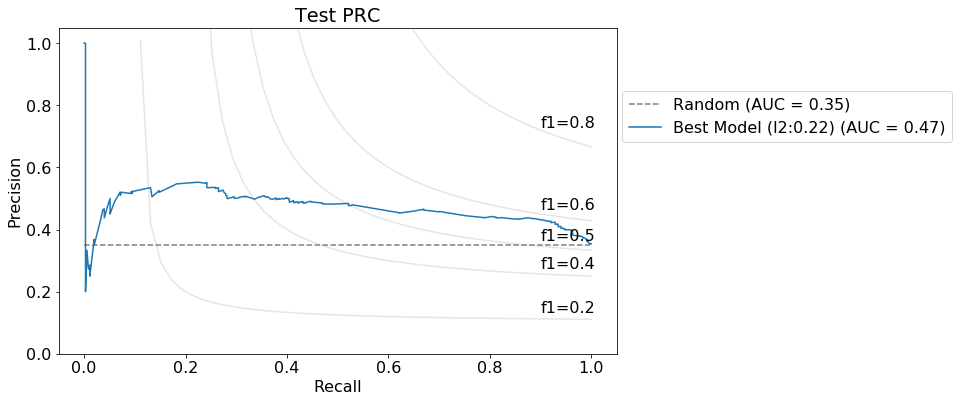

In [35]:
aucs=plot_curve(test_predictions_df,
           candidate_dfs['test'].curated_dsh, plot_title="Test PRC", metric="PR", model_type="curve")

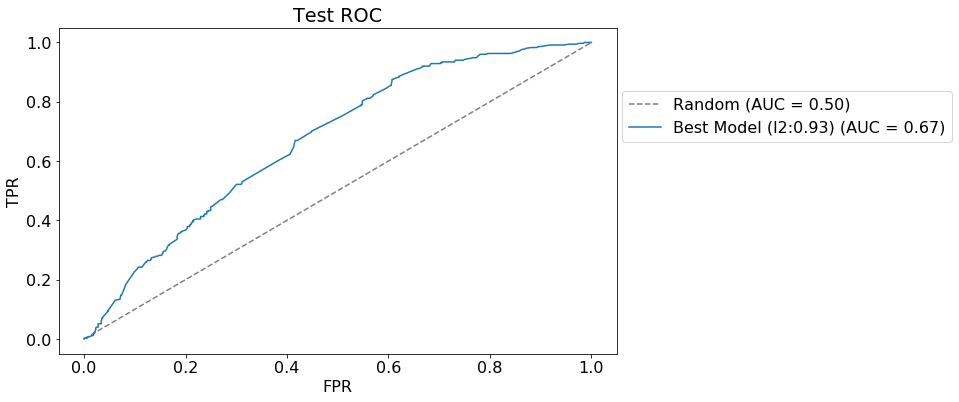

In [36]:
aucs=plot_curve(pd.DataFrame(predictions[:,0], columns=["Best Model (l2:0.93)"]),
           candidate_dfs['test'].curated_dsh, plot_title="Test ROC", metric="ROC", model_type="curve")

In [37]:
training_marginals_df = pd.DataFrame(
    label_model.predict_proba(correct_L), 
    columns=["pos_class_marginal", "neg_class_marginal"]
)
training_marginals_df['candidate_id'] = (
    total_candidates_df
    .query("split==0&disease_mention_count==1&gene_mention_count==1")
    .candidate_id
    .sort_values()
    .values
)
training_marginals_df.to_csv("single_task_data/training_marginals.tsv", sep="\t", index=False)
training_marginals_df.head(2)

,pos_class_marginal,neg_class_marginal,candidate_id
0,0.181399,0.818601,21422
1,0.094911,0.905089,21427


# Word Vectors

This notebook block contains word vectors to be used for the deep learning models. Using facebook's fasttext model, we trained a skipgram model using the sentences in the training set. Each word vector contains 300 dimensions. A validation check for these word embeddings is produced below with the top ten most similar words for diabetes.

In [32]:
if os.path.isfile("single_task_data/training_word_vectors.bin"):
    model = KeyedVectors.load_word2vec_format("single_task_data/training_word_vectors.bin")
#Train a fasttext model
else:
    model = FastText(words_to_embed, window=2, negative=10, iter=50, sg=1, workers=4, alpha=0.005, size=300, seed=100)
    (
    model
    .wv
    .save_word2vec_format(
        "single_task_data/training_word_vectors.bin", 
        fvocab="single_task_data/training_word_vocab.txt", 
        binary=False
        )
    )

In [33]:
model.most_similar("diabetes")

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('pre-diabetes', 0.8766809105873108),
 ('prediabetes', 0.8696415424346924),
 ('mellitus', 0.7737096548080444),
 ('diabetics', 0.7734858989715576),
 ('diabetes-related', 0.7379483580589294),
 ('diabetic', 0.7280935049057007),
 ('obese/diabetic', 0.6865474581718445),
 ('diabetes-associated', 0.6775882244110107),
 ('prediabetics', 0.6699253916740417),
 ('t2dm', 0.6697803139686584)]

In [34]:
word_dict_df = pd.DataFrame(
    [(word,idx) for idx, word in enumerate(model.vocab.keys(), 2)], 
    columns=["word", "index"]
)
word_dict_df = word_dict_df.append({"word":'*unknown*', "index":1}, ignore_index=True)
word_dict_df.to_csv("single_task_data/word_dictionary.tsv.xz", compression="xz", sep="\t", index=False)
word_dict = {word:index for word, index in word_dict_df[["word", "index"]].values}
word_dict_df.head(2)

,word,index
0,of,2
1,~~[[2,3


In [35]:
def embed_word_to_index(cand):
    return [word_dict[word] if word in word_dict else 1 for word in cand]

In [36]:
def generate_embedded_df(candidates):
    words_to_embed = [
        (
        mark_sentence(
            candidate_to_tokens(cand), 
            [
                    (cand[0].get_word_start(), cand[0].get_word_end(), 1),
                    (cand[1].get_word_start(), cand[1].get_word_end(), 2)
            ]
        ), cand.id)
        for cand in tqdm_notebook(candidates)
    ]
    embed_df = pd.DataFrame(list(map(lambda x: embed_word_to_index(x[0]), words_to_embed)))
    embed_df['candidate_id'] = list(map(lambda x: x[1], words_to_embed))
    embed_df['sen_length'] = list(map(lambda x: len(x[0]), words_to_embed))
    return embed_df

In [64]:
# Code to validate that the embedded rows align with the candidates
candidate_query = (
    total_candidates_df
    .query("split==0&disease_mention_count==1&gene_mention_count==1")
    .head(5)
    .candidate_id
    .astype(int)
    .tolist()
)
# Get the candidates
candidates = session.query(DiseaseGene).filter(DiseaseGene.id.in_(candidate_query)).all()

# Generate the correct output for each word
correct_words_to_embed=[
        (
        mark_sentence(
            candidate_to_tokens(cand), 
            [
                    (cand[0].get_word_start(), cand[0].get_word_end(), 1),
                    (cand[1].get_word_start(), cand[1].get_word_end(), 2)
            ]
        ), cand.id)
        for cand in tqdm_notebook(candidates)
    ]

correct_embedded_words = list(map(lambda x: (embed_word_to_index(x[0]), x[1]), correct_words_to_embed))                            
embedded_train = generate_embedded_df(candidates)

# Confirm the dataframe contains the correct rows for each candidate
for words in correct_embedded_words:
    test_query = embedded_train.query("candidate_id==@words[1]").fillna(0).values.tolist()[0][:-2]
    for pair in zip(words[0], [col for col in test_query if col != 0]):
        assert pair[0] == pair[1]

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

In [44]:
training_data_df = generate_embedded_df(
    session
    .query(DiseaseGene)
    .filter(DiseaseGene.id.in_(
        total_candidates_df
        .query("split==0&disease_mention_count==1&gene_mention_count==1")
        .candidate_id
        .astype(int)
        .tolist()
    ))
    .all()
)
training_data_df.to_csv("single_task_data/training_dataframe.tsv.xz", sep="\t", compression="xz", index=False)
training_data_df.head(2)

HBox(children=(IntProgress(value=0, max=658603), HTML(value='')))

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,candidate_id,sen_length
0,64,3,6078,4,16215,17,12,459,5.0,377.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33113153,30
1,55,117,294,22,3,3256,4,11,89.0,3483.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21468,44


In [45]:
dev_data_df = generate_embedded_df(
    session
    .query(DiseaseGene)
    .filter(DiseaseGene.id.in_(
        candidate_dfs['dev']['candidate_id']
        .values
        .tolist()
    ))
    .all()
)
dev_data_df.to_csv("single_task_data/dev_dataframe.tsv.xz", sep="\t", compression="xz", index=False)
dev_data_df.head(2)

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

,0,1,2,3,4,5,6,7,8,9,...,184,185,186,187,188,189,190,191,candidate_id,sen_length
0,9,529,2,2963,72,26,9,14475,436,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21841,63
1,15,36,21,2051,10,8,1,12,394,32771,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82680,72


In [46]:
test_data_df = generate_embedded_df(
    session
    .query(DiseaseGene)
    .filter(DiseaseGene.id.in_(
        candidate_dfs['test']['candidate_id']
        .values
        .tolist()
    ))
    .all()
)
test_data_df.to_csv("single_task_data/test_dataframe.tsv.xz", sep="\t", compression="xz", index=False)
test_data_df.head(2)

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,165,166,candidate_id,sen_length
0,3914,192,8,15,10719,10,7465,1016,142,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23356,50
1,9,584,20,3,22521,4,28,66,94,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23367,22
